# Analysis & Plots for Asphalt Mixture level test results

This notebook include the codes for analysis and plotting the asphalt mixture level test results, including the Dynamic Modulus (DM), Cyclic Fatigue (CF), IDEAL-CT, IDEAL-RT, Hamburg Wheel Tracking Test (HWTT), etc. The test results are provided for the materials from polymer-modified lanes and one control lane in PTF project. 

Author: Farhad Abdollahi (farhad.abdollahi.ctr@dot.gov)

Date: 07/10/2025

____

In [1]:
# Importing the required libraries. 
import os
import ast
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
from Binder_LTPG_DeltaTc import Calc_LTPG_DeltaTc
from Binder_DENT import Calc_DENT
from Binder_FrequencySweep import Analyze_FrequencySweep_Data

In [2]:
# User defined variables. 
MainDataFileName = './Data.xlsx'
OutputDir        = '../_Figures'
PLOT             = False

In [3]:
def Binary_to_Array(BinaryArr, StrShape, StrDtype):
    """
    This function converts the binary bytes into a np.ndarray. This is the reverse function for the "Array_to_Binary".

    :param BinaryArr: Serialized binary bytes of the array.
    :param StrShape: Shape of the array as string. 
    :param StrDtype: type of the data in array as string.
    """
    Shape = ast.literal_eval(StrShape)
    # Shape = int(StrShape[1:-1].split(',')[0])
    return np.frombuffer(BinaryArr, dtype=StrDtype).reshape(Shape)

_____

## Reading and Analysis of Input Data

### IDEAL-CT

This section include reading the IDEAL-CT results from the input data file. CT-values for each mixture specimen was already calculated, and therefore, there is no specific analysis performed in this section, other than combining the results. 

In [4]:
IDEALCT = pd.read_excel(MainDataFileName, sheet_name='IDEAL-CT', usecols='A:U', skiprows=1, 
                        names=['Lane', 'Field_Aging', 'Lab_Aging', 'Bnumber', 'RepNum', 'CTIndex', 
                               'PeakLoad', 'Disp_Peak_Load', 'P85', 'P75', 'P65', 'l85', 'l75', 'l65', 'Slope75', 
                               'Work', 'Work_Avail', 'Gf', 'Height', 'Diameter', 'DispRate'])
IDEALCT.head()

,Lane,Field_Aging,Lab_Aging,Bnumber,RepNum,CTIndex,PeakLoad,Disp_Peak_Load,P85,P75,...,l85,l75,l65,Slope75,Work,Work_Avail,Gf,Height,Diameter,DispRate
0,1,0-Month,STOA,7031,2,75.581192,21.725918,3.296332,18.467030,16.294438,...,4.556065,4.957575,5.375705,5.301330,116.383344,116.383344,12317.261926,62.0,152.4,50.087386
1,1,0-Month,STOA,7031,3,130.511431,17.710715,3.613201,15.054108,13.283036,...,5.030806,5.535138,6.069166,3.411284,115.824281,113.134539,12238.354984,62.1,152.4,50.082331
2,1,0-Month,STOA,7031,4,141.404679,18.283584,3.645261,15.541046,13.712688,...,5.395804,5.923364,6.465295,3.419118,117.536049,116.952082,12439.256758,62.0,152.4,50.113609
3,1,0-Month,STOA,7031,5,93.637394,18.424215,3.421453,15.660583,13.818161,...,5.109096,5.521401,5.918625,4.551833,111.159844,111.159844,11764.440332,62.0,152.4,50.063744
4,1,0-Month,LTOA,7031,1,59.010904,21.452434,3.005431,18.234569,16.089325,...,4.233628,4.576787,4.965377,5.863330,108.862309,108.862309,11484.238145,62.2,152.4,50.047539


In [5]:
def RemoveOutliers(df):
    """
    This function removes the outliers and keep at least 3 replicates.
    """
    while len(df) > 3:
        Index = list(df.index)
        Combinations = list(itertools.combinations(Index, len(Index) - 1))
        COVs = []
        for comb in Combinations:
            CT = df.loc[list(comb), 'CTIndex'].to_numpy()
            COVs.append(CT.std() / CT.mean() * 100)
        if max(COVs) - min(COVs) > 10:
            df = df.loc[list(Combinations[np.argmin(COVs)])]
        else:
            break
    return df

In [6]:
# Aggregate the results and calculate the HTPG into a new "data" DataFrame. 
data = {'Lane': [], 'Field_Aging': [], 'Lab_Aging': [], 'ID': [], 
        'CT_avg': [], 'CT_std': [], 'CT_data': [], 'CT_num': [], 
        'Gf_avg': [], 'Gf_std': [], 'Gf_data': [], 
        'lm_avg': [], 'lm_std': [], 'lm_data': []}      # l75 / |m75|
for ln in IDEALCT['Lane'].unique():
    lndf = IDEALCT[IDEALCT['Lane'] == ln]
    for fage in lndf['Field_Aging'].unique():
        fagedf = lndf[lndf['Field_Aging'] == fage]
        for lage in fagedf['Lab_Aging'].unique():
            lagedf = fagedf[fagedf['Lab_Aging'] == lage]
            lagedf = RemoveOutliers(lagedf)
            NumData = len(lagedf)
            Bnumber = lagedf.iloc[0, 3]
            CT = lagedf['CTIndex'].to_numpy()
            Gf = lagedf['Gf'].to_numpy()
            l75= lagedf['l75'].to_numpy()
            Slope = lagedf['Slope75'].to_numpy()
            lm = l75 / Slope
            # Save the results. 
            data['Lane'].append(ln)
            data['Field_Aging'].append(fage)
            data['Lab_Aging'].append(lage)
            data['ID'].append(Bnumber)
            data['CT_avg'].append(CT.mean())
            data['CT_std'].append(CT.std())
            data['CT_data'].append(','.join([f'{num:.2f}' for num in CT]))
            data['CT_num'].append(NumData)
            data['Gf_avg'].append(Gf.mean())
            data['Gf_std'].append(Gf.std())
            data['Gf_data'].append(','.join([f'{num:.2f}' for num in Gf]))
            data['lm_avg'].append(lm.mean())
            data['lm_std'].append(lm.std())
            data['lm_data'].append(','.join([f'{num:.2f}' for num in lm]))
data = pd.DataFrame(data)
data.head()

,Lane,Field_Aging,Lab_Aging,ID,CT_avg,CT_std,CT_data,CT_num,Gf_avg,Gf_std,Gf_data,lm_avg,lm_std,lm_data
0,1,0-Month,STOA,7031,121.851168,20.439806,"130.51,141.40,93.64",3,12147.350692,282.908275,"12238.35,12439.26,11764.44",1.522676,0.223513,"1.62,1.73,1.21"
1,1,0-Month,LTOA,7031,55.607067,6.134116,"59.01,46.78,48.84,59.31,55.35,64.36",6,11254.724031,278.652757,"11484.24,10795.78,11026.91,11622.29,11223.55,1...",0.751284,0.068882,"0.78,0.66,0.67,0.78,0.75,0.86"
2,2,0-Month,STOA,7036,289.814776,14.614943,"306.43,274.30,276.28,302.25",4,11759.532125,487.403941,"12184.60,11889.31,12029.28,10934.94",3.759611,0.294318,"3.81,3.50,3.50,4.22"
3,2,0-Month,LTOA,7036,207.216348,33.593123,"171.56,224.63,220.38,165.59,173.35,251.17,243.83",7,12327.308197,1043.606821,"10635.32,11599.17,13388.14,12195.52,12252.95,1...",2.557642,0.363774,"2.46,2.95,2.50,2.05,2.17,3.15,2.62"
4,3,0-Month,STOA,7041,105.775134,7.258752,"113.13,100.07,100.78,98.90,116.00",5,10207.442756,465.553754,"9910.59,10105.83,11125.75,9888.99,10006.06",1.582890,0.145850,"1.74,1.51,1.38,1.52,1.76"


### Hamburg Wheel Tracking Test (HWTT)

This section reading the HWTT results and plotting the corrected rut depth (CRD) and stripping inflection point (SIP).

In [7]:
HWTT = pd.read_excel(MainDataFileName, sheet_name='HWTT', skiprows=0, usecols='A:O', 
                     names=['Lane', 'Field_Aging', 'Lab_Aging', 'Bnumber', 'RepNum', 'MaxRut', 'MaxPass', 
                            'CRD10', 'CRD20', 'SN', 'SIP', 'SIPAdj', 'CreepSlope', 'StripSlope', 'StripSlopeAdj'])
HWTT.head()

,Lane,Field_Aging,Lab_Aging,Bnumber,RepNum,MaxRut,MaxPass,CRD10,CRD20,SN,SIP,SIPAdj,CreepSlope,StripSlope,StripSlopeAdj
0,1,0-Month,STOA,7031,1,3.65,20000,2.222107,2.634806,9194.153103,16270.337298,38493.958591,0.000101,0.000130,0.001288
1,1,0-Month,STOA,7031,2,4.47,20000,2.299722,2.717861,6016.126704,16565.453391,24512.388289,0.000104,0.000371,0.007832
2,1,0-Month,STOA,7031,3,6.78,20000,2.529488,2.993899,4953.767576,17044.939752,20837.409789,0.000150,0.001051,0.004562
3,1,0-Month,STOA,7031,4,10.43,20000,2.962662,3.486221,4329.806931,16998.112641,17922.237730,0.000223,0.001932,0.002573
4,1,0-Month,STOA,7031,5,11.61,20000,2.728918,3.203218,3528.602546,16035.235989,16142.074746,0.000274,0.001782,0.001823


In [8]:
# Create new columns for the LTPG and DeltaTc values. 
NewCols = ['CRD20_num'] + [f'{Props}_{metric}' for Props in ['CRD20', 'CRD10', 'SIP', 'SN', 'TRD', "Pass"] for metric in ['avg', 'std', 'data']]
for col in NewCols:
    data[col] = np.nan
# Iterate over the rows in "data" DataFrame.
for ln in data['Lane'].unique():
    lndf = data[data['Lane'] == ln]
    for age in lndf['Field_Aging'].unique():
        agedf = lndf[(lndf['Field_Aging'] == age) & (lndf['Lab_Aging'] == 'STOA')]
        if len(agedf) != 1:
            raise Exception(f'More than one record with field aging of {age} and lane number of {ln} found!!')
        else:
            idx = agedf.index[0]
        df = HWTT[(HWTT['Lane'] == ln) & (HWTT['Field_Aging'] == age)]
        # Extract the HWTT results. 
        CRD20 = df['CRD20'].to_numpy()
        CRD10 = df['CRD10'].to_numpy()
        SN    = df['SN'].to_numpy()
        SIP   = df['SIP'].to_numpy()
        TRD   = df['MaxRut'].to_numpy()
        Pass  = df['MaxPass'].to_numpy()
        # Save the results into "data" dataframe. 
        data.loc[idx, 'CRD20_num']  = len(CRD20)
        data.loc[idx, 'CRD20_avg']  = CRD20.mean()
        data.loc[idx, 'CRD20_std']  = CRD20.std()
        data.loc[idx, 'CRD20_data'] = ','.join([f'{num:.2f}' for num in CRD20])
        data.loc[idx, 'CRD10_avg']  = CRD10.mean()
        data.loc[idx, 'CRD10_std']  = CRD10.std()
        data.loc[idx, 'CRD10_data'] = ','.join([f'{num:.2f}' for num in CRD10])
        data.loc[idx, 'SN_avg']  = SN.mean()
        data.loc[idx, 'SN_std']  = SN.std()
        data.loc[idx, 'SN_data'] = ','.join([f'{num:.2f}' for num in SN])
        data.loc[idx, 'SIP_avg']  = SIP.mean()
        data.loc[idx, 'SIP_std']  = SIP.std()
        data.loc[idx, 'SIP_data'] = ','.join([f'{num:.2f}' for num in SIP])
        data.loc[idx, 'TRD_avg']  = TRD.mean()
        data.loc[idx, 'TRD_std']  = TRD.std()
        data.loc[idx, 'TRD_data'] = ','.join([f'{num:.2f}' for num in TRD])
        data.loc[idx, 'Pass_avg'] = Pass.mean()
        data.loc[idx, 'Pass_std'] = Pass.std()
        data.loc[idx, 'Pass_data']= ','.join([f'{num:.2f}' for num in Pass])
data.head()

C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_18040\445093989.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.63,2.72,2.99,3.49,3.20' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[idx, 'CRD20_data'] = ','.join([f'{num:.2f}' for num in CRD20])
C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_18040\445093989.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.22,2.30,2.53,2.96,2.73' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[idx, 'CRD10_data'] = ','.join([f'{num:.2f}' for num in CRD10])
C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_18040\445093989.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

,Lane,Field_Aging,Lab_Aging,ID,CT_avg,CT_std,CT_data,CT_num,Gf_avg,Gf_std,...,SIP_data,SN_avg,SN_std,SN_data,TRD_avg,TRD_std,TRD_data,Pass_avg,Pass_std,Pass_data
0,1,0-Month,STOA,7031,121.851168,20.439806,"130.51,141.40,93.64",3,12147.350692,282.908275,...,"16270.34,16565.45,17044.94,16998.11,16035.24",5604.491372,1970.415758,"9194.15,6016.13,4953.77,4329.81,3528.60",7.388000,3.160256,"3.65,4.47,6.78,10.43,11.61",20000.0,0.0,"20000.00,20000.00,20000.00,20000.00,20000.00"
1,1,0-Month,LTOA,7031,55.607067,6.134116,"59.01,46.78,48.84,59.31,55.35,64.36",6,11254.724031,278.652757,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0-Month,STOA,7036,289.814776,14.614943,"306.43,274.30,276.28,302.25",4,11759.532125,487.403941,...,"18659.45,18694.12,19581.05",17014.937811,1230.837115,"16096.06,16194.07,18754.68",4.326667,0.421294,"3.74,4.71,4.53",20000.0,0.0,"20000.00,20000.00,20000.00"
3,2,0-Month,LTOA,7036,207.216348,33.593123,"171.56,224.63,220.38,165.59,173.35,251.17,243.83",7,12327.308197,1043.606821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,0-Month,STOA,7041,105.775134,7.258752,"113.13,100.07,100.78,98.90,116.00",5,10207.442756,465.553754,...,"13282.93,13266.88,15861.92,13914.31",2519.397651,779.855176,"2055.79,1989.75,3865.72,2166.34",14.287500,1.839828,"16.14,15.68,11.46,13.87",20000.0,0.0,"20000.00,20000.00,20000.00,20000.00"


Reading the HWTT Curves. 


In [9]:
Curves = pd.read_excel(MainDataFileName, sheet_name='HWTT Curves', skiprows=4, usecols='A:P', 
                       names=['Pass', 'L1-1', 'L1-2', 'L1-3', 'L1-4', 'L1-5', 
                              'L2-1', 'L2-2', 'L2-3', 'L3-1', 'L3-2', 'L3-3', 'L3-4', 
                              'L4-1', 'L4-2', 'L4-3'])
HWTTCurves = {}
for ln in [1, 2, 3, 4]:
    X = Curves['Pass'].to_numpy()
    Cols = [col for col in Curves.columns if f'L{ln}' in col]
    if ln == 4: Cols.remove('L4-1')
    Y = np.zeros((len(X), len(Cols)))
    MaxIndx = X.shape[0]
    for i in range(len(Cols)):
        TempY = Curves[Cols[i]].to_numpy()
        Indx  = np.where(~np.isnan(TempY))[0]
        Y[Indx, i] = TempY[Indx]
        if MaxIndx > Indx[-1]:
            MaxIndx = Indx[-1]
    X = X[:MaxIndx]
    Y = Y[:MaxIndx, :]
    # ------------------------------------------------------------------------------------------------------------------
    # Perform the Monte-Carlo analysis. 
    NumSamples = 1000 
    MonteCarloSamples = np.zeros((X.shape[0], NumSamples))
    for i in range(X.shape[0]):     # Iterate over each pass number. 
        Avg = Y[i, :].mean()
        Std = Y[i, :].std()
        MonteCarloSamples[i, :] = np.random.normal(loc=Avg, scale=Std, size=NumSamples)
    # Compute average curve
    AverageCurve = np.mean(MonteCarloSamples, axis=1)
    # Compute boundaries (e.g., 5th and 95th percentiles)
    LowerBoundary = np.percentile(MonteCarloSamples, 5, axis=1)
    UpperBoundary = np.percentile(MonteCarloSamples, 95, axis=1)
    # ------------------------------------------------------------------------------------------------------------------
    # Smoothing the noises. 
    AverageCurve  = gaussian_filter(AverageCurve, sigma=10)
    LowerBoundary = gaussian_filter(LowerBoundary, sigma=10)
    UpperBoundary = gaussian_filter(UpperBoundary, sigma=10)
    # ------------------------------------------------------------------------------------------------------------------
    # Save the results. 
    HWTTCurves[f'L{ln}'] = {'Avg': AverageCurve, 'X': X, 'Lower': LowerBoundary, 'Upper': UpperBoundary}

### IDEAL-RT

This section reads the IDEAL-RT results and aggregate them together for each lane. 


In [10]:
IDEALRT = pd.read_excel(MainDataFileName, sheet_name='IDEAL-RT', usecols='A:O', skiprows=0, 
                        names=['Lane', 'Field_Aging', 'Lab_Aging', 'Bnumber', 'RepNum', 
                               'RT', 'RTAdj', 'PeakLoad', 'DispPeak', 'TotalWork', 'AvailWork', 'ShearStrength', 
                               'Height', 'Diameter', 'DispRate'])
IDEALRT.head()

,Lane,Field_Aging,Lab_Aging,Bnumber,RepNum,RT,RTAdj,PeakLoad,DispPeak,TotalWork,AvailWork,ShearStrength,Height,Diameter,DispRate
0,1,0-Month,STOA,7031,1,110.421486,113.835240,5.421993,5.194318,80.843612,67.959914,1.668502e+06,62.1,152.4,50.048768
1,1,0-Month,STOA,7031,2,109.982683,113.647758,5.400446,4.674767,81.476649,66.539409,1.661872e+06,62.1,152.4,50.047613
2,1,0-Month,STOA,7031,3,110.941364,113.295456,5.465064,4.937954,84.219350,66.600674,1.676358e+06,62.3,152.4,50.042578
3,1,0-Month,STOA,7031,4,111.275861,112.578293,5.463945,4.667613,79.056554,66.557740,1.681412e+06,62.1,152.4,50.043731
4,2,0-Month,STOA,7036,1,65.404874,57.214874,3.211556,4.187331,59.367738,42.954084,9.882876e+05,62.1,152.4,50.042359


In [11]:
# Create new columns for the LTPG and DeltaTc values. 
NewCols = ['RT_num'] + [f'{Props}_{metric}' for Props in ['RT', 'RTAdj', 'Work'] for metric in ['avg', 'std', 'data']]
for col in NewCols:
    data[col] = np.nan
# Iterate over the rows in "data" DataFrame.
for ln in data['Lane'].unique():
    lndf = data[data['Lane'] == ln]
    for age in lndf['Field_Aging'].unique():
        agedf = lndf[(lndf['Field_Aging'] == age) & (lndf['Lab_Aging'] == 'STOA')]
        if len(agedf) != 1:
            raise Exception(f'More than one record with field aging of {age} and lane number of {ln} found!!')
        else:
            idx = agedf.index[0]
        df = IDEALRT[(IDEALRT['Lane'] == ln) & (IDEALRT['Field_Aging'] == age)]
        # Extract the HWTT results. 
        RT    = df['RT'].to_numpy()
        RTAdj = df['RTAdj'].to_numpy()
        Work  = df['TotalWork'].to_numpy()
        # Save the results into "data" dataframe. 
        data.loc[idx, 'RT_num']  = len(RT)
        data.loc[idx, 'RT_avg']  = RT.mean()
        data.loc[idx, 'RT_std']  = RT.std()
        data.loc[idx, 'RT_data'] = ','.join([f'{num:.2f}' for num in RT])
        data.loc[idx, 'RTAdj_avg']  = RTAdj.mean()
        data.loc[idx, 'RTAdj_std']  = RTAdj.std()
        data.loc[idx, 'RTAdj_data'] = ','.join([f'{num:.2f}' for num in RTAdj])
        data.loc[idx, 'Work_avg']  = Work.mean()
        data.loc[idx, 'Work_std']  = Work.std()
        data.loc[idx, 'Work_data'] = ','.join([f'{num:.2f}' for num in Work])
data.head()

C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_18040\3071194601.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '110.42,109.98,110.94,111.28' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[idx, 'RT_data'] = ','.join([f'{num:.2f}' for num in RT])
C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_18040\3071194601.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '113.84,113.65,113.30,112.58' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[idx, 'RTAdj_data'] = ','.join([f'{num:.2f}' for num in RTAdj])
C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_18040\3071194601.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of p

,Lane,Field_Aging,Lab_Aging,ID,CT_avg,CT_std,CT_data,CT_num,Gf_avg,Gf_std,...,RT_num,RT_avg,RT_std,RT_data,RTAdj_avg,RTAdj_std,RTAdj_data,Work_avg,Work_std,Work_data
0,1,0-Month,STOA,7031,121.851168,20.439806,"130.51,141.40,93.64",3,12147.350692,282.908275,...,4.0,110.655349,0.493460,"110.42,109.98,110.94,111.28",113.339187,0.480145,"113.84,113.65,113.30,112.58",81.399041,1.854448,"80.84,81.48,84.22,79.06"
1,1,0-Month,LTOA,7031,55.607067,6.134116,"59.01,46.78,48.84,59.31,55.35,64.36",6,11254.724031,278.652757,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0-Month,STOA,7036,289.814776,14.614943,"306.43,274.30,276.28,302.25",4,11759.532125,487.403941,...,5.0,70.164861,2.918298,"65.40,68.52,71.37,73.82,71.71",61.363666,2.369096,"57.21,61.40,61.13,64.36,62.71",57.155326,1.779415,"59.37,56.54,56.64,54.41,58.82"
3,2,0-Month,LTOA,7036,207.216348,33.593123,"171.56,224.63,220.38,165.59,173.35,251.17,243.83",7,12327.308197,1043.606821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,0-Month,STOA,7041,105.775134,7.258752,"113.13,100.07,100.78,98.90,116.00",5,10207.442756,465.553754,...,5.0,92.093995,2.318486,"95.59,89.82,91.89,93.70,89.47",90.288852,2.202429,"94.56,89.22,88.67,88.79,90.20",65.283028,2.082203,"67.45,63.69,62.13,67.33,65.82"


### Cyclic Fatigue Sapp value. 


In [12]:
CF = pd.read_excel(MainDataFileName, sheet_name='CF Sapp', usecols='A:F', skiprows=0, 
                   names=['Lane', 'Field_Aging', 'Lab_Aging', 'ID', 'RepNum', 'Sapp'])
CF.head()

,Lane,Field_Aging,Lab_Aging,ID,RepNum,Sapp
0,1,0-Month,STOA,7031,1,18.9
1,1,0-Month,STOA,7031,2,15.9
2,1,0-Month,STOA,7031,3,16.9
3,1,0-Month,STOA,7031,4,19.1
4,1,0-Month,STOA,7031,5,18.9


In [13]:
# Create new columns for the LTPG and DeltaTc values. 
NewCols = ['Sapp_num'] + [f'{Props}_{metric}' for Props in ['Sapp'] for metric in ['avg', 'std', 'data']]
for col in NewCols:
    data[col] = np.nan
# Iterate over the rows in "data" DataFrame.
for ln in data['Lane'].unique():
    lndf = data[data['Lane'] == ln]
    for age in lndf['Field_Aging'].unique():
        agedf = lndf[(lndf['Field_Aging'] == age)]
        for labage in agedf['Lab_Aging'].unique():
            lagedf = agedf[agedf['Lab_Aging'] == labage]
            if len(lagedf) != 1:
                raise Exception(f'More than one record with field aging of {age} and lane number of {ln} and lab aging of {labage} found!!')
            else:
                idx = lagedf.index[0]
            df = CF[(CF['Lane'] == ln) & (CF['Field_Aging'] == age) & (CF['Lab_Aging'] == labage)]
            # Extract the HWTT results. 
            Sapp = df['Sapp'].to_numpy()
            # Save the results into "data" dataframe. 
            data.loc[idx, 'Sapp_num']  = len(Sapp)
            data.loc[idx, 'Sapp_avg']  = Sapp.mean()
            data.loc[idx, 'Sapp_std']  = Sapp.std()
            data.loc[idx, 'Sapp_data'] = ','.join([f'{num:.2f}' for num in Sapp])
data.head()

C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_18040\3983745890.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.90,15.90,16.90,19.10,18.90' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[idx, 'Sapp_data'] = ','.join([f'{num:.2f}' for num in Sapp])


,Lane,Field_Aging,Lab_Aging,ID,CT_avg,CT_std,CT_data,CT_num,Gf_avg,Gf_std,...,RTAdj_avg,RTAdj_std,RTAdj_data,Work_avg,Work_std,Work_data,Sapp_num,Sapp_avg,Sapp_std,Sapp_data
0,1,0-Month,STOA,7031,121.851168,20.439806,"130.51,141.40,93.64",3,12147.350692,282.908275,...,113.339187,0.480145,"113.84,113.65,113.30,112.58",81.399041,1.854448,"80.84,81.48,84.22,79.06",5.0,17.9400,1.298615,"18.90,15.90,16.90,19.10,18.90"
1,1,0-Month,LTOA,7031,55.607067,6.134116,"59.01,46.78,48.84,59.31,55.35,64.36",6,11254.724031,278.652757,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,17.6670,2.007585,"20.59,15.34,16.39,18.35"
2,2,0-Month,STOA,7036,289.814776,14.614943,"306.43,274.30,276.28,302.25",4,11759.532125,487.403941,...,61.363666,2.369096,"57.21,61.40,61.13,64.36,62.71",57.155326,1.779415,"59.37,56.54,56.64,54.41,58.82",5.0,25.5800,3.024169,"22.00,23.80,23.70,29.20,29.20"
3,2,0-Month,LTOA,7036,207.216348,33.593123,"171.56,224.63,220.38,165.59,173.35,251.17,243.83",7,12327.308197,1043.606821,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,20.8794,5.010590,"13.25,17.39,22.10,27.37,24.29"
4,3,0-Month,STOA,7041,105.775134,7.258752,"113.13,100.07,100.78,98.90,116.00",5,10207.442756,465.553754,...,90.288852,2.202429,"94.56,89.22,88.67,88.79,90.20",65.283028,2.082203,"67.45,63.69,62.13,67.33,65.82",5.0,19.3000,0.846168,"20.30,18.60,20.10,18.10,19.40"


_________

## Plotting Section

### IDEAL-CT 

Plotting the IDEAL-CT bar plots and interaction diagram. 

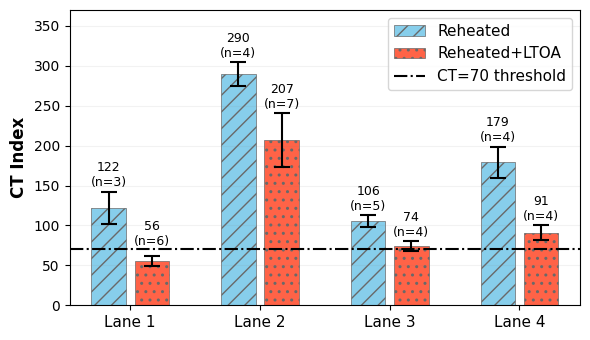

In [26]:
STOA_CT_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CT_avg'].tolist()[0] for ln in range(1, 5)]
STOA_CT_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CT_std'].tolist()[0] for ln in range(1, 5)]
STOA_CT_num = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CT_num'].tolist()[0] for ln in range(1, 5)]
LTOA_CT_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['CT_avg'].tolist()[0] for ln in range(1, 5)]
LTOA_CT_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['CT_std'].tolist()[0] for ln in range(1, 5)]
LTOA_CT_num = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['CT_num'].tolist()[0] for ln in range(1, 5)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.bar([1, 4, 7, 10], height=STOA_CT_avg, yerr=STOA_CT_std, width=0.8, 
       edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='Reheated',
       error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.bar([2, 5, 8, 11], height=LTOA_CT_avg, yerr=LTOA_CT_std, width=0.8, 
       edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='Reheated+LTOA',
       error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# Plotting the threshold. 
ax.axhline(y=70, color='k', ls='-.', lw=1.5, label='CT=70 threshold')
ax.set_ylim([0, 370])
ax.set_xticks([1.5, 4.5, 7.5, 10.5])
ax.set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, color='k', rotation=0)
ax.set_ylabel('CT Index', fontsize=12, fontweight='bold', color='k')
for i in range(4):
    ax.text([1, 4, 7, 10][i], STOA_CT_avg[i] + STOA_CT_std[i] + 3, f"{STOA_CT_avg[i]:.0f}\n(n={STOA_CT_num[i]})", 
            ha='center', va='bottom', fontsize=9)
    offset = 3 if i != 0 else 10
    ax.text([2, 5, 8, 11][i], LTOA_CT_avg[i] + LTOA_CT_std[i] + offset, f"{LTOA_CT_avg[i]:.0f}\n(n={LTOA_CT_num[i]})", 
            ha='center', va='bottom', fontsize=9)
ax.set_xlim([0.1, 11.9])
ax.grid(axis='y', color='gray', alpha=0.1)
hnd, lbl = ax.get_legend_handles_labels()
ax.legend(handles=[hnd[i] for i in [1, 2, 0]], labels=[lbl[i] for i in [1, 2, 0]], 
          fontsize=11, ncol=1, loc='upper right')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'IDEALCT_CTIndex.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'IDEALCT_CTIndex.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'IDEALCT_CTIndex.svg'), format='svg')

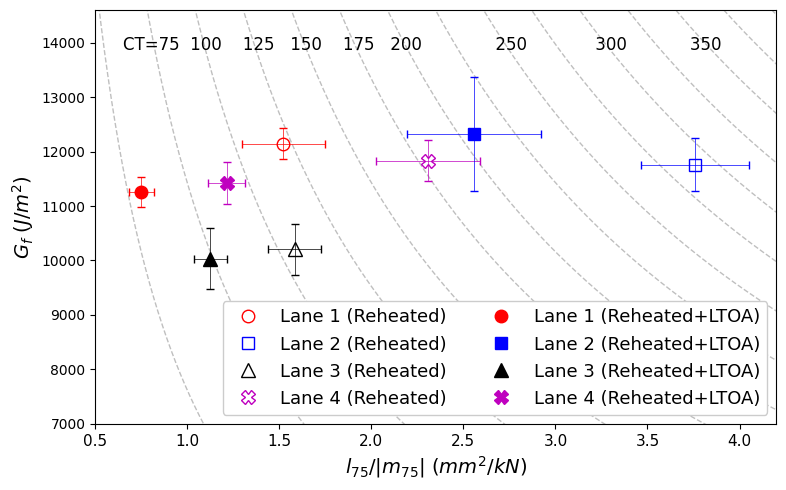

In [29]:
STOA_Gf_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Gf_avg'].tolist()[0] for ln in range(1, 5)]
STOA_Gf_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Gf_std'].tolist()[0] for ln in range(1, 5)]
LTOA_Gf_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['Gf_avg'].tolist()[0] for ln in range(1, 5)]
LTOA_Gf_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['Gf_std'].tolist()[0] for ln in range(1, 5)]
STOA_lm_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['lm_avg'].tolist()[0] for ln in range(1, 5)]
STOA_lm_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['lm_std'].tolist()[0] for ln in range(1, 5)]
LTOA_lm_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['lm_avg'].tolist()[0] for ln in range(1, 5)]
LTOA_lm_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['lm_std'].tolist()[0] for ln in range(1, 5)]
# Plot the interaction diagram. 
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# Plot the guide lines. 
Diameter = 6 * 2.54 * 10
LM = np.linspace(0.2, 8, num=10000)
for CT in [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]:
    Gf = CT / LM * Diameter
    ax.plot(LM, Gf, ls='--', lw=1, color='gray', alpha=0.5)
# ----------------------------------------------------------------------------------------------------------------------
# Plot the points: Lane 1 (Reheated). 
ax.plot(STOA_lm_avg[0], STOA_Gf_avg[0], 
        ls='', marker='o', ms=9, color='r', markerfacecolor='none', label='Lane 1 (Reheated)')
ax.errorbar(STOA_lm_avg[0], STOA_Gf_avg[0], xerr=STOA_lm_std[0], yerr=STOA_Gf_std[0], 
            fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5)
# Plot the points: Lane 2 (Reheated). 
ax.plot(STOA_lm_avg[1], STOA_Gf_avg[1], 
        ls='', marker='s', ms=9, color='b', markerfacecolor='none', label='Lane 2 (Reheated)')
ax.errorbar(STOA_lm_avg[1], STOA_Gf_avg[1], xerr=STOA_lm_std[1], yerr=STOA_Gf_std[1], 
            fmt='', ecolor='b', capsize=3, markersize=6, color='b', lw=0.5)
# Plot the points: Lane 3 (Reheated). 
ax.plot(STOA_lm_avg[2], STOA_Gf_avg[2], 
        ls='', marker='^', ms=10, color='k', markerfacecolor='none', label='Lane 3 (Reheated)')
ax.errorbar(STOA_lm_avg[2], STOA_Gf_avg[2], xerr=STOA_lm_std[2], yerr=STOA_Gf_std[2], 
            fmt='', ecolor='k', capsize=3, markersize=6, color='k', lw=0.5)
# Plot the points: Lane 3 (Reheated). 
ax.plot(STOA_lm_avg[3], STOA_Gf_avg[3], 
        ls='', marker='X', ms=10, color='m', markerfacecolor='none', label='Lane 4 (Reheated)')
ax.errorbar(STOA_lm_avg[3], STOA_Gf_avg[3], xerr=STOA_lm_std[3], yerr=STOA_Gf_std[3], 
            fmt='', ecolor='m', capsize=3, markersize=6, color='m', lw=0.5)
# ----------------------------------------------------------------------------------------------------------------------
# Plot the points: Lane 1 (Reheated+LTOA). 
ax.plot(LTOA_lm_avg[0], LTOA_Gf_avg[0], 
        ls='', marker='o', ms=9, color='r', markerfacecolor='r', label='Lane 1 (Reheated+LTOA)')
ax.errorbar(LTOA_lm_avg[0], LTOA_Gf_avg[0], xerr=LTOA_lm_std[0], yerr=LTOA_Gf_std[0], 
            fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5)
# Plot the points: Lane 2 (Reheated+LTOA). 
ax.plot(LTOA_lm_avg[1], LTOA_Gf_avg[1], 
        ls='', marker='s', ms=9, color='b', markerfacecolor='b', label='Lane 2 (Reheated+LTOA)')
ax.errorbar(LTOA_lm_avg[1], LTOA_Gf_avg[1], xerr=LTOA_lm_std[1], yerr=LTOA_Gf_std[1], 
            fmt='', ecolor='b', capsize=3, markersize=6, color='b', lw=0.5)
# Plot the points: Lane 3 (Reheated+LTOA). 
ax.plot(LTOA_lm_avg[2], LTOA_Gf_avg[2], 
        ls='', marker='^', ms=10, color='k', markerfacecolor='k', label='Lane 3 (Reheated+LTOA)')
ax.errorbar(LTOA_lm_avg[2], LTOA_Gf_avg[2], xerr=LTOA_lm_std[2], yerr=LTOA_Gf_std[2], 
            fmt='', ecolor='k', capsize=3, markersize=6, color='k', lw=0.5)
# Plot the points: Lane 4 (Reheated+LTOA). 
ax.plot(LTOA_lm_avg[3], LTOA_Gf_avg[3], 
        ls='', marker='X', ms=10, color='m', markerfacecolor='m', label='Lane 4 (Reheated+LTOA)')
ax.errorbar(LTOA_lm_avg[3], LTOA_Gf_avg[3], xerr=LTOA_lm_std[3], yerr=LTOA_Gf_std[3], 
            fmt='', ecolor='m', capsize=3, markersize=6, color='m', lw=0.5)
# # ----------------------------------------------------------------------------------------------------------------------
ax.set_xticks([0.5 + 0.5 * i for i in range(14)])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.set_xlim([0.5, 4.2])
ax.set_ylim([7000, 14600])
ax.set_xlabel('$l_{75}$/|$m_{75}$| ($mm^2$/$kN$)', fontsize=14)
ax.set_ylabel('$G_f$ ($J$/$m^2$)', fontsize=14)
ax.set_yticks([i for i in range(7000, 15000, 1000)])
ax.set_yticklabels([f'{i}' for i in range(7000, 15000, 1000)])
ax.legend(loc='lower right', fontsize=13, ncol=2, framealpha=1.0)
ax.text(0.65, 13800, 'CT=75  100    125   150    175   200              250             300            350', 
        ha='left', va='bottom', fontsize=12, color='k')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'IDEALCT_Interaction.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'IDEALCT_Interaction.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'IDEALCT_Interaction.svg'), format='svg')

### Cyclic Fatigue Sapp 


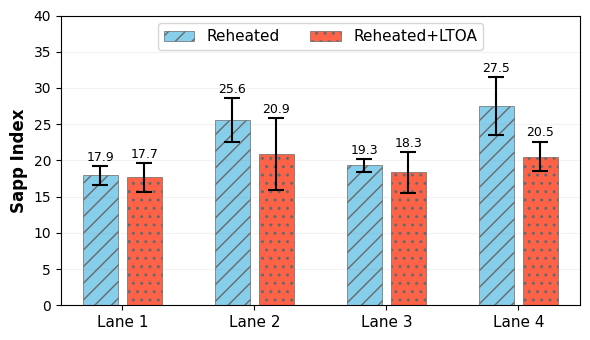

In [32]:
STOA_Sapp_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Sapp_avg'].tolist()[0] for ln in range(1, 5)]
STOA_Sapp_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Sapp_std'].tolist()[0] for ln in range(1, 5)]
STOA_Sapp_num = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Sapp_num'].tolist()[0] for ln in range(1, 5)]
LTOA_Sapp_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['Sapp_avg'].tolist()[0] for ln in range(1, 5)]
LTOA_Sapp_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['Sapp_std'].tolist()[0] for ln in range(1, 5)]
LTOA_Sapp_num = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'LTOA')]['Sapp_num'].tolist()[0] for ln in range(1, 5)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.bar([1, 4, 7, 10], height=STOA_Sapp_avg, yerr=STOA_Sapp_std, width=0.8, 
       edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='Reheated',
       error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.bar([2, 5, 8, 11], height=LTOA_Sapp_avg, yerr=LTOA_Sapp_std, width=0.8, 
       edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='Reheated+LTOA',
       error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.set_ylim([0, 40])
ax.set_xticks([1.5, 4.5, 7.5, 10.5])
ax.set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, color='k', rotation=0)
ax.set_ylabel('Sapp Index', fontsize=12, fontweight='bold', color='k')
for i in range(4):
    ax.text([1, 4, 7, 10][i], STOA_Sapp_avg[i] + STOA_Sapp_std[i] + 0.3, f"{STOA_Sapp_avg[i]:.1f}", 
            ha='center', va='bottom', fontsize=9)
    ax.text([2, 5, 8, 11][i], LTOA_Sapp_avg[i] + LTOA_Sapp_std[i] + 0.3, f"{LTOA_Sapp_avg[i]:.1f}", 
            ha='center', va='bottom', fontsize=9)
ax.set_xlim([0.1, 11.9])
ax.grid(axis='y', color='gray', alpha=0.1)
ax.legend(fontsize=11, ncol=2, loc='upper center')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'Sapp_Index.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'Sapp_Index.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'Sapp_Index.svg'), format='svg')

### HWTT and IDEAL-RT

Plotting the Corrected Rut Depth (CRD) at 20k passes, as well as the SN or SIP, which ever works better. In addition, plot the RT-Index values. 

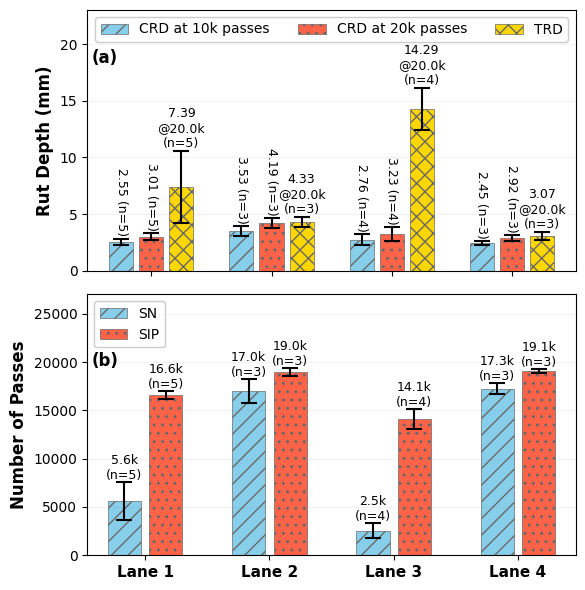

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
# First, plot the CRD20. 
NumData   = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CRD20_num'].tolist()[0] for ln in [1, 2, 3, 4]]
CRD20_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CRD20_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
CRD20_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CRD20_std'].tolist()[0] for ln in [1, 2, 3, 4]]
CRD10_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CRD10_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
CRD10_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CRD10_std'].tolist()[0] for ln in [1, 2, 3, 4]]
TRD_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['TRD_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
TRD_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['TRD_std'].tolist()[0] for ln in [1, 2, 3, 4]]
Pass_avg= [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Pass_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
Pass_std= [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Pass_std'].tolist()[0] for ln in [1, 2, 3, 4]]
ax[0].bar([1, 5, 9, 13], height=CRD10_avg, yerr=CRD10_std, width=0.8, 
          edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='CRD at 10k passes',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax[0].bar([2, 6, 10, 14], height=CRD20_avg, yerr=CRD20_std, width=0.8, 
          edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='CRD at 20k passes',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax[0].bar([3, 7, 11, 15], height=TRD_avg, yerr=TRD_std, width=0.8, 
          edgecolor='dimgray', lw=0.5, color='gold', hatch='xx', label='TRD',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i in range(4):
    ax[0].text([1, 5, 9, 13][i], CRD10_avg[i] + CRD10_std[i] + 0.2, f'{CRD10_avg[i]:.2f} (n={NumData[i]:.0f})', 
               ha='center', va='bottom', fontsize=9, rotation=-90)
    ax[0].text([2, 6, 10, 14][i], CRD20_avg[i] + CRD20_std[i] + 0.2, f'{CRD20_avg[i]:.2f} (n={NumData[i]:.0f})', 
               ha='center', va='bottom', fontsize=9, rotation=-90)
    ax[0].text([3, 7, 11, 15][i], TRD_avg[i] + TRD_std[i] + 0.1, f'{TRD_avg[i]:.2f}\n@{Pass_avg[i] / 1e3:.1f}k\n(n={NumData[i]:.0f})', 
               ha='center', va='bottom', fontsize=9)
ax[0].set_ylim([0, 23])
ax[0].set_ylabel('Rut Depth (mm)', fontsize=12, fontweight='bold', color='k')
ax[0].legend(fontsize=10, framealpha=1.0, ncol=3, loc='upper center')
ax[0].set_xticks([2, 6, 10, 14])
# ----------------------------------------------------------------------------------------------------------------------
SN_avg  = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['SN_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
SN_std  = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['SN_std'].tolist()[0] for ln in [1, 2, 3, 4]]
SIP_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['SIP_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
SIP_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['SIP_std'].tolist()[0] for ln in [1, 2, 3, 4]]
ax[1].bar([1, 4, 7, 10], height=SN_avg, yerr=SN_std, width=0.8, 
          edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='SN',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax[1].bar([2, 5, 8, 11], height=SIP_avg, yerr=SIP_std, width=0.8, 
          edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='SIP',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i in range(4):

    ax[1].text([1, 4, 7, 10][i], SN_avg[i] + SN_std[i] + 0.1, f'{SN_avg[i] / 1e3:,.1f}k\n(n={NumData[i]:.0f})', 
               ha='center', va='bottom', fontsize=9)
    ax[1].text([2, 5, 8, 11][i], SIP_avg[i] + SIP_std[i] + 0.1, f'{SIP_avg[i] / 1e3:,.1f}k\n(n={NumData[i]:.0f})', 
               ha='center', va='bottom', fontsize=9)
ax[1].set_ylim([0, 27000])
ax[1].set_ylabel('Number of Passes', fontsize=12, fontweight='bold', color='k')
ax[1].legend(fontsize=10, framealpha=1.0, ncol=1, loc='upper left')
ax[1].set_xlim([0.1, 11.9])
ax[1].set_xticks([1.5, 4.5, 7.5, 10.5])
# # ----------------------------------------------------------------------------------------------------------------------
# NumRT     = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['RT_num'].tolist()[0] for ln in [1, 2, 3, 4]]
# RT_avg    = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['RT_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
# RT_std    = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['RT_std'].tolist()[0] for ln in [1, 2, 3, 4]]
# RTAdj_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['RTAdj_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
# RTAdj_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['RTAdj_std'].tolist()[0] for ln in [1, 2, 3, 4]]
# ax[2].bar([1, 4, 7, 10], height=RT_avg, yerr=RT_std, width=0.8, 
#           edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='No Adjustment',
#           error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# ax[2].bar([2, 5, 8, 11], height=RTAdj_avg, yerr=RTAdj_std, width=0.8, 
#           edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='Air Void Adjusted',
#           error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
# for i in range(4):
#     ax[2].text([1, 4, 7, 10][i], RT_avg[i] + RT_std[i] + 0.1, f'{RT_avg[i]:,.0f}\n(n={NumRT[i]:.0f})', 
#                ha='center', va='bottom', fontsize=9)
#     ax[2].text([2, 5, 8, 11][i], RTAdj_avg[i] + RTAdj_std[i] + 0.1, f'{RTAdj_avg[i]:,.0f} (n={NumRT[i]:.0f})', 
#                ha='center', va='bottom', fontsize=9, rotation=0)
# ax[2].set_ylim([40, 150])
# ax[2].set_ylabel('RT Index', fontsize=12, fontweight='bold', color='k')
# ax[2].legend(fontsize=10, framealpha=1.0, ncol=2, loc='upper left')
# ax[2].set_xlim([0.1, 11.9])
# ax[2].set_xticks([1.5, 4.5, 7.5, 10.5])
# ----------------------------------------------------------------------------------------------------------------------
for ax1 in ax:
    ax1.set_xticklabels(['', '', '', ''], fontsize=11, color='k', rotation=0)
    ax1.grid(axis='y', which='both', color='gray', alpha=0.1)
ax[1].set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold', color='k', rotation=0)
ax[0].text(0.01, 0.85, '(a)', transform=ax[0].transAxes, fontsize=12, fontweight='bold', ha='left', va='top')
ax[1].text(0.01, 0.78, '(b)', transform=ax[1].transAxes, fontsize=12, fontweight='bold', ha='left', va='top')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'HWTT_IDEALRT.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'HWTT_IDEALRT.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'HWTT_IDEALRT.svg'), format='svg')

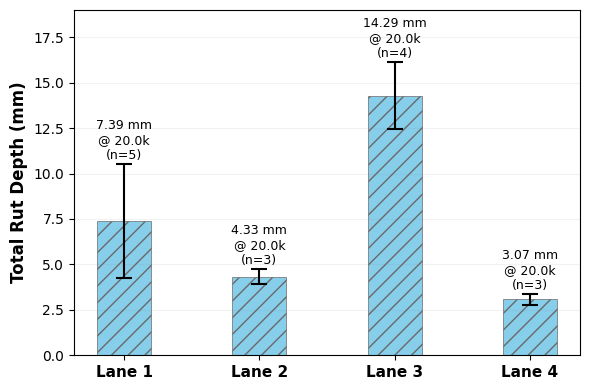

In [18]:
# Plotting the total rut depth.
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# First, plot the CRD20. 
NumData   = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CRD20_num'].tolist()[0] for ln in [1, 2, 3, 4]]
TRD_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['TRD_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
TRD_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['TRD_std'].tolist()[0] for ln in [1, 2, 3, 4]]
Pass_avg= [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Pass_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
Pass_std= [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Pass_std'].tolist()[0] for ln in [1, 2, 3, 4]]
ax.bar([1, 2, 3, 4], height=TRD_avg, yerr=TRD_std, width=0.4, 
          edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='at 10k passes',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i in range(4):
    ax.text([1, 2, 3, 4][i], TRD_avg[i] + TRD_std[i] + 0.1, f'{TRD_avg[i]:.2f} mm\n@ {Pass_avg[i] / 1e3:.1f}k\n(n={NumData[i]:.0f})', 
               ha='center', va='bottom', fontsize=9)
ax.set_ylim([0, 19])
ax.set_ylabel('Total Rut Depth (mm)', fontsize=12, fontweight='bold', color='k')
for ax1 in [ax]:
    ax1.set_xticks([1, 2, 3, 4])
    ax1.grid(axis='y', which='both', color='gray', alpha=0.1)
    ax.set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=11, fontweight='bold', color='k', rotation=0)
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'HWTT_TRD.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'HWTT_TRD.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'HWTT_TRD.svg'), format='svg')

This plot is requested by Behnam

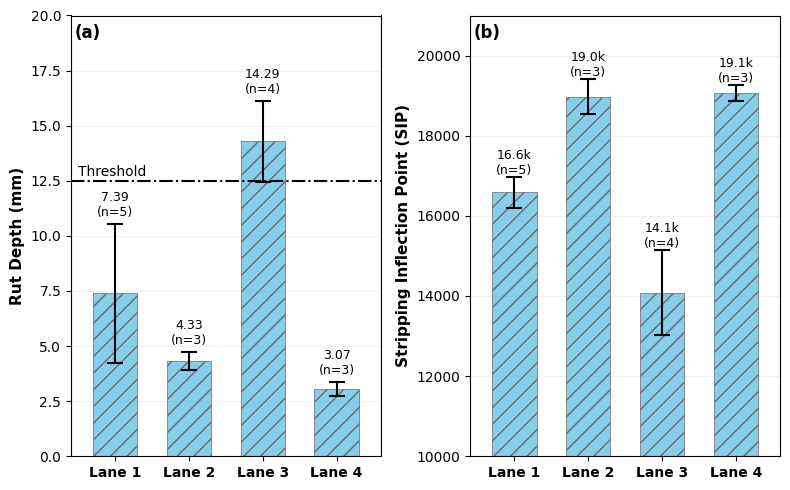

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
# First, plot the CRD20. 
NumData   = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CRD20_num'].tolist()[0] for ln in [1, 2, 3, 4]]
TRD_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['TRD_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
TRD_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['TRD_std'].tolist()[0] for ln in [1, 2, 3, 4]]
Pass_avg= [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Pass_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
Pass_std= [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['Pass_std'].tolist()[0] for ln in [1, 2, 3, 4]]
ax[0].bar([1, 2, 3, 4], height=TRD_avg, yerr=TRD_std, width=0.6, 
          edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i in range(4):
    ax[0].text([1, 2, 3, 4][i], TRD_avg[i] + TRD_std[i] + 0.2, f'{TRD_avg[i]:.2f}\n(n={NumData[i]:.0f})', 
               ha='center', va='bottom', fontsize=9, rotation=0)
# Plot the threshold. 
ax[0].axhline(y=12.5, ls='-.', lw=1.5, color='k', label='Threshold')
ax[0].text(0.5, 12.6, 'Threshold', fontsize=10, fontweight='normal', ha='left', va='bottom')
ax[0].set_ylabel('Rut Depth (mm)', fontsize=11, fontweight='bold', color='k')
ax[0].set_xticks([1, 2, 3, 4])
ax[0].set_ylim([0, 20])
ax[0].set_xlim([0.4, 4.6])
# ----------------------------------------------------------------------------------------------------------------------
SIP_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['SIP_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
SIP_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['SIP_std'].tolist()[0] for ln in [1, 2, 3, 4]]
ax[1].bar([1, 2, 3, 4], height=SIP_avg, yerr=SIP_std, width=0.6, 
          edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='SIP',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i in range(4):
    ax[1].text([1, 2, 3, 4][i], SIP_avg[i] + SIP_std[i] + 0.1, f'{SIP_avg[i] / 1e3:,.1f}k\n(n={NumData[i]:.0f})', 
               ha='center', va='bottom', fontsize=9)
ax[1].set_ylim([10000, 21000])
ax[1].set_ylabel('Stripping Inflection Point (SIP)', fontsize=11, fontweight='bold', color='k')
ax[1].set_xticks([1, 2, 3, 4])
ax[1].set_xlim([0.4, 4.6])
# ----------------------------------------------------------------------------------------------------------------------
for ax1 in ax:
    ax1.set_xticklabels(['', '', '', ''], fontsize=11, color='k', rotation=0)
    ax1.grid(axis='y', which='both', color='gray', alpha=0.1)
    ax1.set_xticklabels(['Lane 1', 'Lane 2', 'Lane 3', 'Lane 4'], fontsize=10, fontweight='bold', color='k', rotation=0)
ax[0].text(0.01, 0.98, '(a)', transform=ax[0].transAxes, fontsize=12, fontweight='bold', ha='left', va='top')
ax[1].text(0.01, 0.98, '(b)', transform=ax[1].transAxes, fontsize=12, fontweight='bold', ha='left', va='top')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'HWTT_TRD_SIP.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'HWTT_TRD_SIP.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'HWTT_TRD_SIP.svg'), format='svg')

Plotting the average rutting curves. 

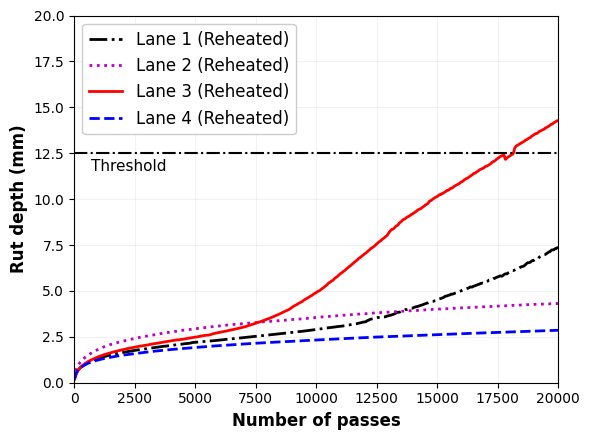

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
Colors = ['k', 'm', 'r', 'b']
LS = ['-.', ':', '-', '--']
for i, ln in enumerate(HWTTCurves.keys()):
    X   = HWTTCurves[ln]['X']
    Avg = HWTTCurves[ln]['Avg']
    Low = HWTTCurves[ln]['Lower']
    Up  = HWTTCurves[ln]['Upper']
    plt.plot(X, Avg, color=Colors[i], ls=LS[i], lw=2, label=f'Lane {i + 1} (Reheated)')
    # plt.fill_between(X, Low, Up, color=Colors[i], alpha=0.2)
ax.axhline(y=12.5, ls='-.', lw=1.5, color='k')
ax.text(700, 12.2, 'Threshold', ha='left', va='top', fontsize=11)
ax.set_ylabel('Rut depth (mm)', fontsize=12, fontweight='bold', color='k')
ax.set_xlabel('Number of passes', fontsize=12, fontweight='bold', color='k')
ax.legend(fontsize=12, framealpha=1, loc='upper left')
ax.grid(which='both', color='gray', alpha=0.1)
ax.set_ylim([0, 20])
ax.set_xlim([-0, 20000])
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'HWTT_Curves.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'HWTT_Curves.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'HWTT_Curves.svg'), format='svg')

### Balanced Mix Design Diagram

Plotting the Balance Mix Design diagram. 

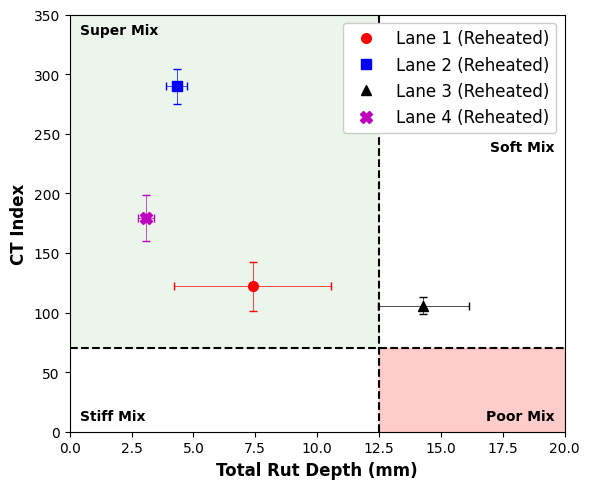

In [50]:
# First, Extract the Rut depth and CT Index values. 
TRD_avg = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['TRD_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
TRD_std = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['TRD_std'].tolist()[0] for ln in [1, 2, 3, 4]]
CT_avg  = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CT_avg'].tolist()[0] for ln in [1, 2, 3, 4]]
CT_std  = [data[(data['Lane'] == ln) & (data['Lab_Aging'] == 'STOA')]['CT_std'].tolist()[0] for ln in [1, 2, 3, 4]]
# ----------------------------------------------------------------------------------------------------------------------
# Plotting section. 
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# Plotting the diagram properties. 
ax.axvline(x=12.5, ls='--', lw=1.5, color='k')
ax.axhline(y=70.0, ls='--', lw=1.5, color='k')
ax.fill_between([0, 12.5], [70, 70], [350, 350], color='green', alpha=0.08)
ax.fill_between([12.5, 20], [0, 0], [70, 70], color='r', alpha=0.2)
ax.text(0.98, 0.02, 'Poor Mix', fontsize=10, fontweight='bold', color='k', transform=ax.transAxes, 
        ha='right', va='bottom')
ax.text(0.02, 0.02, 'Stiff Mix', fontsize=10, fontweight='bold', color='k', transform=ax.transAxes, 
        ha='left', va='bottom')
ax.text(0.02, 0.98, 'Super Mix', fontsize=10, fontweight='bold', color='k', transform=ax.transAxes, 
        ha='left', va='top')
ax.text(0.98, 0.70, 'Soft Mix', fontsize=10, fontweight='bold', color='k', transform=ax.transAxes, 
        ha='right', va='top')
# Plot the points: Lane 1. 
ax.plot(TRD_avg[0], CT_avg[0], 
        ls='', marker='o', ms=7, color='r', markerfacecolor='r', label='Lane 1 (Reheated)')
ax.errorbar(TRD_avg[0], CT_avg[0], xerr=TRD_std[0], yerr=CT_std[0], 
            fmt='', ecolor='r', capsize=3, markersize=6, color='r', lw=0.5)
# Plot the points: Lane 2. 
ax.plot(TRD_avg[1], CT_avg[1], 
        ls='', marker='s', ms=7, color='b', markerfacecolor='b', label='Lane 2 (Reheated)')
ax.errorbar(TRD_avg[1], CT_avg[1], xerr=TRD_std[1], yerr=CT_std[1], 
            fmt='', ecolor='b', capsize=3, markersize=6, color='b', lw=0.5)
# Plot the points: Lane 3. 
ax.plot(TRD_avg[2], CT_avg[2], 
        ls='', marker='^', ms=7, color='k', markerfacecolor='k', label='Lane 3 (Reheated)')
ax.errorbar(TRD_avg[2], CT_avg[2], xerr=TRD_std[2], yerr=CT_std[2], 
            fmt='', ecolor='k', capsize=3, markersize=6, color='k', lw=0.5)
# Plot the points: Lane 4. 
ax.plot(TRD_avg[3], CT_avg[3], 
        ls='', marker='X', ms=8, color='m', markerfacecolor='m', label='Lane 4 (Reheated)')
ax.errorbar(TRD_avg[3], CT_avg[3], xerr=TRD_std[3], yerr=CT_std[3], 
            fmt='', ecolor='m', capsize=3, markersize=6, color='m', lw=0.5)
# Plot properties. 
ax.set_xlim([0, 20])
ax.set_ylim([0, 350])
ax.legend(fontsize=12, ncol=1, loc='upper right', framealpha=1)
ax.set_xlabel('Total Rut Depth (mm)', fontsize=12, fontweight='bold', color='k')
ax.set_ylabel('CT Index', fontsize=12, fontweight='bold', color='k')
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'BMD_Diagram.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'BMD_Diagram.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'BMD_Diagram.svg'), format='svg')

_______

### Compaction Curve (Gradation)

In [22]:
Gradation = pd.read_excel(MainDataFileName, sheet_name='Gradation', usecols='A:L', skiprows=1, 
                          names=['Sieve_in', 'Sieve_mm', 'Dense', 'SMA', 'L1', 'L2', 'L3', 'L4', 
                                 'Dmin', 'Dmax', 'Smin', 'Smax'])
Gradation['Power_0.45']  = Gradation['Sieve_mm']  ** 0.45
Gradation

,Sieve_in,Sieve_mm,Dense,SMA,L1,L2,L3,L4,Dmin,Dmax,Smin,Smax,Power_0.45
0,"2""",50.000,100.0,100,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,5.814823
1,"1.5""",37.500,100.0,100,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,5.108743
2,"1""",25.000,100.0,100,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,4.256700
3,"3/4""",19.000,100.0,100,100.0,99.4,100.0,100.0,NaN,NaN,NaN,NaN,3.762176
4,"1/2""",12.500,99.0,90,99.6,92.3,99.6,99.8,95.0,100.0,83.0,93.0,3.116087
5,"3/8""",9.500,90.0,61,91.6,66.2,91.0,92.0,NaN,90.0,NaN,80.0,2.754074
6,# 4,4.750,64.0,26,64.1,27.9,62.4,60.8,58.0,80.0,22.0,28.0,2.016100
7,#8,2.360,41.0,21,36.7,19.7,38.6,35.5,34.0,50.0,16.0,24.0,1.471670
8,#30,0.600,21.0,15,19.7,15.2,18.9,16.6,NaN,23.0,15.0,20.0,0.794636
9,#50,0.300,16.0,13,15.0,13.5,14.5,12.7,NaN,NaN,NaN,NaN,0.581707


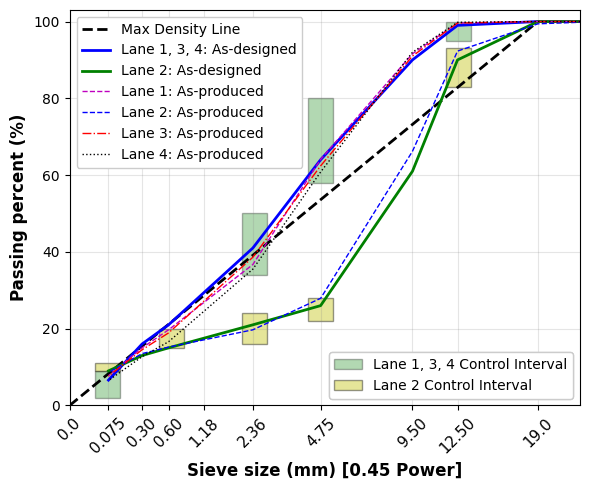

In [23]:
# Plot the results. 
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot([0, 19 ** 0.45], [0, 100], ls='--', lw=2, color='k', label='Max Density Line')
ax.plot(Gradation['Power_0.45'], Gradation['Dense'], ls='-', lw=2, color='b', label='Lane 1, 3, 4: As-designed')
ax.plot(Gradation['Power_0.45'], Gradation['SMA'], ls='-',   lw=2, color='g', label='Lane 2: As-designed')
ax.plot(Gradation['Power_0.45'], Gradation['L1'], ls='--',   lw=1, color='m', label='Lane 1: As-produced')
ax.plot(Gradation['Power_0.45'], Gradation['L2'], ls='--',   lw=1, color='b', label='Lane 2: As-produced')
ax.plot(Gradation['Power_0.45'], Gradation['L3'], ls='-.',   lw=1, color='r', label='Lane 3: As-produced')
ax.plot(Gradation['Power_0.45'], Gradation['L4'], ls=':',    lw=1, color='k', label='Lane 4: As-produced')
handles, labels = ax.get_legend_handles_labels()
# Add the control highlights. 
p1 = ax.add_patch(patches.Rectangle((11.7 ** 0.45, 95), 0.2, 5,  edgecolor='k',  facecolor='g', alpha=0.3, linewidth=1, linestyle='-', label='Lane 1, 3, 4 Control Interval'))
p2 = ax.add_patch(patches.Rectangle((11.7 ** 0.45, 83), 0.2, 10, edgecolor='k',  facecolor='y', alpha=0.4, linewidth=1, linestyle='-', label='Lane 2 Control Interval'))
ax.add_patch(patches.Rectangle((4.25 ** 0.45, 58), 0.2, 22, edgecolor='k', facecolor='g', alpha=0.3, linewidth=1, linestyle='-'))
ax.add_patch(patches.Rectangle((4.25 ** 0.45, 22), 0.2, 6, edgecolor='k', facecolor='y', alpha=0.4, linewidth=1, linestyle='-'))
ax.add_patch(patches.Rectangle((2.06 ** 0.45, 34), 0.2, 16, edgecolor='k', facecolor='g', alpha=0.3, linewidth=1, linestyle='-'))
ax.add_patch(patches.Rectangle((2.06 ** 0.45, 16), 0.2, 8, edgecolor='k', facecolor='y', alpha=0.4, linewidth=1, linestyle='-'))
ax.add_patch(patches.Rectangle((0.03 ** 0.45, 2),  0.2, 7,  edgecolor='k', facecolor='g', alpha=0.3, linewidth=1, linestyle='-'))
ax.add_patch(patches.Rectangle((0.03 ** 0.45, 9),  0.2, 2,  edgecolor='k', facecolor='y', alpha=0.4, linewidth=1, linestyle='-'))
ax.add_patch(patches.Rectangle((0.48 ** 0.45, 15),  0.2, 5,  edgecolor='k', facecolor='y', alpha=0.4, linewidth=1, linestyle='-'))
# Fix the x-axis ticks. 
SieveSizes = np.array([0, 0.075, 0.30, 0.60, 1.18, 2.36, 4.75, 9.50, 12.50, 19.0])
ax.set_xticks(list(SieveSizes ** 0.45))
ax.set_xticklabels(['0.0', '0.075', '0.30', '0.60', '1.18', '2.36', '4.75', '9.50', '12.50', '19.0'], rotation=45, fontsize=11)
ax.set_xlim([0, 23 ** 0.45])
ax.set_ylim([0, 103])
ax.set_xlabel('Sieve size (mm) [0.45 Power]', fontsize=12, fontweight='bold', color='k')
ax.set_ylabel('Passing percent (%)', fontsize=12, fontweight='bold', color='k')
ax.grid(which='both', color='gray', alpha=0.2)
legend1 = ax.legend(handles=handles, labels=labels, fontsize=10, framealpha=1.0, fancybox=True, loc='upper left')
legend2 = ax.legend(handles=[p1, p2], labels=['Lane 1, 3, 4 Control Interval', 'Lane 2 Control Interval'], 
                    fontsize=10, framealpha=1.0, fancybox=True, loc='lower right')
ax.add_artist(legend1)
ax.add_artist(legend2)
fig.tight_layout()
if PLOT:
    fig.savefig(os.path.join(OutputDir, f'Gradation.png'), format='png', dpi=800)
    fig.savefig(os.path.join(OutputDir, f'Gradation.pdf'), format='pdf')
    fig.savefig(os.path.join(OutputDir, f'Gradation.svg'), format='svg')

In [24]:
# # Read the HWTT curves and show them in Excel file. 
# conn = sqlite3.connect('C:\\Users\\Farhad.Abdollahi.ctr\\OneDrive - DOT OST\\GitHub_HWTT_Analysis_Tool\\HWTT_Analysis_Tool\\example\\PTF5_DB_New.db')
# cursor = conn.cursor()
# import ast

# cursor.execute('PRAGMA Table_info(HWTT)')
# cursor.fetchall()

# cursor.execute('SELECT Bnumber, Lane_Num, RepNumber, TPP_Max_Rut_mm, Data, Data_shape, Data_dtype, Valid_Max_Pass, Wheel_Side FROM HWTT WHERE Bnumber IN (7031, 7036, 7041, 7113)')
# Cont = cursor.fetchall()

# def Binary_to_Array(BinaryArr, StrShape, StrDtype):
#     """
#     This function converts the binary bytes into a np.ndarray. This is the reverse function for the "Array_to_Binary".

#     :param BinaryArr: Serialized binary bytes of the array.
#     :param StrShape: Shape of the array as string. 
#     :param StrDtype: type of the data in array as string.
#     """
#     Shape = ast.literal_eval(StrShape)
#     # Shape = int(StrShape[1:-1].split(',')[0])
#     return np.frombuffer(BinaryArr, dtype=StrDtype).reshape(Shape)

# A = np.zeros((21000, len(Cont) * 2))
# for i in range(len(Cont)):
#     bnum = Cont[i][0]
#     ln = Cont[i][1]
#     Rep = Cont[i][2]
#     Rut = Cont[i][3]
#     X = Binary_to_Array(Cont[i][4], Cont[i][5], Cont[i][6])
#     X = X[:2, :].T
#     MaxP = Cont[i][7]
#     Indx = np.where(X[:, 0] <= MaxP)[0]
#     X = X[Indx, :]
#     idx = 2 * i
#     A[0, idx] = bnum
#     A[1, idx] = ln
#     A[2, idx] = Rep
#     A[3, idx] = Rut
#     A[4:X.shape[0] + 4, idx:idx+2] = X.copy()
# A = A[~np.all(A == 0, axis=1)]
# np.savetxt('test.csv', A, delimiter=',')